<a href="https://colab.research.google.com/github/Spocklight/Fake_News_Detection/blob/master/Master_Algoritmos_Neuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Detección de noticias falsas</center></h1>
<h3><center>Alejandro Sierra Fernández</center></h3>
<h4><center>01/08/2022</center></h4>

*   <h2>Aplicación de algoritmos neuronales</h2>

<font color='darkblue'> En este Notebook exploraremos el desempeño que tienen sobres nuestros datos distintas redes neuronales. Empezamos cargando librerías y nuestro dataset.  </font>

In [ ]:
!pip install SciKeras

from google.colab import drive
from tqdm import tqdm
from pprint import pprint
import warnings 
import pickle  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
import tensorflow as tf

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from tensorflow import keras
from keras.models import Sequential
from keras. layers import Dense, Flatten, Input, LSTM, Dropout, Conv1D, MaxPool1D, Bidirectional
from keras import regularizers
from scikeras.wrappers import KerasClassifier




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Fake_News/'
pickle_in = open(path + 'ISOT_topic_sentiment_pickle', 'rb')
ISOT = pickle.load(pickle_in)

Mounted at /content/drive


In [ ]:
display(ISOT.dtypes)

title                           object
text                            object
subject                         object
date                    datetime64[ns]
normaliza_text                  object
normaliza_title                 object
clean_text                      object
clean_title                     object
char_len_title                   int64
char_len_text                    int64
char_len_title_t                 int64
char_len_text_t                  int64
token_text_len                   int64
token_title_len                  int64
prop_uppercase_text            float64
prop_uppercase_title           float64
prop_long_text                 float64
prop_long_title                float64
target                          object
normaliza_b_filter              object
topic_modelling                 object
topic_modelling_max              int64
Sentimiento_text               float64
Subjetividad_text              float64
Análisis_text                    int64
Sentimiento_title        

<font color='darkblue'> A continuación, preparamos los datasets *train* y *target* y aplicamos las transformaciones ya comentadas en el notebook de algoritmos no neuronales..</n> 

In [ ]:
train, test = train_test_split(ISOT, test_size=0.2, random_state=25)
print(train.shape)
print(test.shape)

(30607, 28)
(7652, 28)


In [ ]:
train['target'].value_counts()

True    16694
Fake    13913
Name: target, dtype: int64

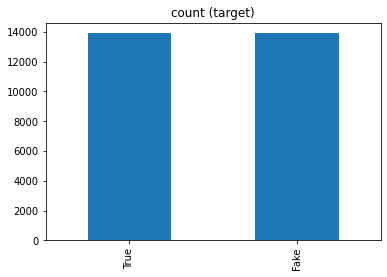

In [ ]:
count_1, count_0 = train["target"].value_counts()

class_0 = train[train.target=='Fake']
class_1 = train[train.target=='True']
class_1_under = class_1.sample(count_0)
train_under = pd.concat([class_1_under, class_0], axis=0)

train_under['target'].value_counts().plot(kind='bar', title='count (target)')
train_under['target'].value_counts()
train = train_under

In [ ]:
train['target'].value_counts()

True    13913
Fake    13913
Name: target, dtype: int64

In [ ]:
train["target"] = (train['target'] == 'True').astype(np.float32)  #True=1, Fake=0
test["target"] = (test['target'] == 'True').astype(np.float32)  #True=1, Fake=0

In [ ]:
vectorizador = TfidfVectorizer(max_features=100,                  
                               ngram_range=(1,3),
                               min_df=10,
                               max_df=0.50,
                               lowercase=False)

vector_title_train = vectorizador.fit_transform(train["clean_title"])
vector_text_train = vectorizador.fit_transform(train["clean_text"])
vector_title_test = vectorizador.fit_transform(test["clean_title"])
vector_text_test = vectorizador.fit_transform(test["clean_text"])

In [ ]:
extra_features_train_d = train[['Sentimiento_text', 'Análisis_text', 'Subjetividad_text', 'Sentimiento_title', 'Análisis_title', 'Subjetividad_title', 'topic_modelling_max',
                              'prop_long_text', 'prop_long_title', 'prop_uppercase_text', 'prop_uppercase_title', 'token_title_len', 'token_text_len',
                              'char_len_title', 'char_len_text']]

extra_features_test_d = test[['Sentimiento_text', 'Análisis_text', 'Subjetividad_text', 'Sentimiento_title', 'Análisis_title', 'Subjetividad_title', 'topic_modelling_max',
                              'prop_long_text', 'prop_long_title', 'prop_uppercase_text', 'prop_uppercase_title', 'token_title_len', 'token_text_len',
                              'char_len_title', 'char_len_text']]

sc = StandardScaler()
extra_features_train = sc.fit_transform(extra_features_train_d)
extra_features_test = sc.transform(extra_features_test_d)

In [ ]:
y_train = train["target"].values
X_train_text = sp.sparse.hstack((vector_text_train, extra_features_train),format='csr')
X_train_title = sp.sparse.hstack((vector_title_train, extra_features_train),format='csr')

y_test = test["target"].values
X_test_text = sp.sparse.hstack((vector_text_test, extra_features_test),format='csr')
X_test_title = sp.sparse.hstack((vector_title_test, extra_features_test),format='csr')

In [ ]:
X_train_text = X_train_text.toarray()
X_train_title = X_train_title.toarray()
X_test_text = X_test_text.toarray()
X_test_title = X_test_title.toarray()


<font color='darkblue'> Definimos una función para mostrar la evolución la función de pérdida y de la precisión.</n>

In [ ]:
def show_loss_accuracy_evolution(hist):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

*   <h3>Redes neuronales densas</h3>

<font color='darkblue'> Definimos la función *create_model* con el primer modelo y que recibe como entrada el número de neuronas de las dos primeras capas densas. Lo hacemos de este modo en lugar de definirlo directamente para poder aplicarle ajuste de parámetros. Para ello empleamos el *KerasClassifier*, que recibe como entrada *create_model*, para después pasarlo a la función *RandomizedSearchCV*</n>

In [ ]:
def create_model(neuron1, neuron2):
  model = Sequential(name='Dense_Tuning_Model')
  model.add(Dense(neuron1, input_shape=(X_train_text.shape[1], ), kernel_initializer='uniform', activation='relu', name="input_layer"))
  model.add(Dropout(0.2), name="first_dropout")
  model.add(Dense(neuron2, kernel_initializer='uniform', activation='relu', name='Dense1'))
  model.add(Dropout(0.2), name="second_dropout")
  model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid', name="output:layer"))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

seed = 7
tf.random.set_seed(seed)

In [ ]:
Dense_tuned = KerasClassifier(build_fn=create_model, epochs=100, batch_size=64, verbose=1)

param_grids = {'model__neuron1': [64, 128, 256], 
               'model__neuron2': [64, 128, 256]}

In [ ]:
grid = RandomizedSearchCV(estimator=Dense_tuned, param_distributions=param_grids, n_iter=5, cv=KFold(n_splits=3), verbose=10, random_state=42)
grid_result = grid.fit(X_train_text, y_train, epochs=5)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START model__neuron1=256, model__neuron2=128......................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 1s 3ms/step - loss: 0.0895 - accuracy: 0.9629
Epoch 2/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0112 - accuracy: 0.9962
Epoch 3/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0084 - accuracy: 0.9971
Epoch 4/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0078 - accuracy: 0.9968
Epoch 5/5
145/145 [==============================] - 0s 1ms/step
[CV 1/3; 1/5] END model__neuron1=256, model__neuron2=128;, score=0.992 total time=   5.9s
[CV 2/3; 1/5] START model__neuron1=256, model__neuron2=128......................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 1s 3ms/step - loss: 0.0862 - accuracy: 0.9790
Epoch 2/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0133 - accuracy: 0.9959
Epoch 3/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0114 - accuracy: 0.9967
Epoch 4/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0084 - accuracy: 0.9975
Epoch 5/5
145/145 [==============================] - 0s 1ms/step
[CV 2/3; 1/5] END model__neuron1=256, model__neuron2=128;, score=0.996 total time=   5.9s
[CV 3/3; 1/5] START model__neuron1=256, model__neuron2=128......................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 1s 3ms/step - loss: 0.0817 - accuracy: 0.9738
Epoch 2/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0122 - accuracy: 0.9961
Epoch 3/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0078 - accuracy: 0.9975
Epoch 4/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0077 - accuracy: 0.9973
Epoch 5/5
145/145 [==============================] - 0s 1ms/step
[CV 3/3; 1/5] END model__neuron1=256, model__neuron2=128;, score=0.986 total time=   6.0s
[CV 1/3; 2/5] START model__neuron1=64, model__neuron2=128.......................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 1s 2ms/step - loss: 0.1285 - accuracy: 0.9508
Epoch 2/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0148 - accuracy: 0.9953
Epoch 3/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0110 - accuracy: 0.9958
Epoch 4/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0088 - accuracy: 0.9967
Epoch 5/5
145/145 [==============================] - 0s 902us/step
[CV 1/3; 2/5] END model__neuron1=64, model__neuron2=128;, score=0.994 total time=   3.5s
[CV 2/3; 2/5] START model__neuron1=64, model__neuron2=128.......................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 66s 2ms/step - loss: 0.1219 - accuracy: 0.9721
Epoch 2/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0154 - accuracy: 0.9957
Epoch 3/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0136 - accuracy: 0.9958
Epoch 4/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0100 - accuracy: 0.9969
Epoch 5/5
145/145 [==============================] - 0s 962us/step
[CV 2/3; 2/5] END model__neuron1=64, model__neuron2=128;, score=0.996 total time= 1.2min
[CV 3/3; 2/5] START model__neuron1=64, model__neuron2=128.......................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 1s 2ms/step - loss: 0.1191 - accuracy: 0.9579
Epoch 2/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0148 - accuracy: 0.9955
Epoch 3/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0098 - accuracy: 0.9971
Epoch 4/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0092 - accuracy: 0.9972
Epoch 5/5
145/145 [==============================] - 0s 897us/step
[CV 3/3; 2/5] END model__neuron1=64, model__neuron2=128;, score=0.988 total time=   3.5s
[CV 1/3; 3/5] START model__neuron1=128, model__neuron2=256......................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 1s 3ms/step - loss: 0.0898 - accuracy: 0.9633
Epoch 2/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0133 - accuracy: 0.9951
Epoch 3/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0086 - accuracy: 0.9971
Epoch 4/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0062 - accuracy: 0.9977
Epoch 5/5
145/145 [==============================] - 0s 1ms/step
[CV 1/3; 3/5] END model__neuron1=128, model__neuron2=256;, score=0.994 total time=   4.7s
[CV 2/3; 3/5] START model__neuron1=128, model__neuron2=256......................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 1s 3ms/step - loss: 0.0883 - accuracy: 0.9770
Epoch 2/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0147 - accuracy: 0.9953
Epoch 3/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0117 - accuracy: 0.9965
Epoch 4/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0091 - accuracy: 0.9976
Epoch 5/5
145/145 [==============================] - 0s 1ms/step
[CV 2/3; 3/5] END model__neuron1=128, model__neuron2=256;, score=0.996 total time=   4.5s
[CV 3/3; 3/5] START model__neuron1=128, model__neuron2=256......................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 1s 2ms/step - loss: 0.0837 - accuracy: 0.9700
Epoch 2/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0115 - accuracy: 0.9967
Epoch 3/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0088 - accuracy: 0.9971
Epoch 4/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0078 - accuracy: 0.9973
Epoch 5/5
145/145 [==============================] - 0s 1ms/step
[CV 3/3; 3/5] END model__neuron1=128, model__neuron2=256;, score=0.986 total time=   4.8s
[CV 1/3; 4/5] START model__neuron1=64, model__neuron2=64........................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 1s 2ms/step - loss: 0.1470 - accuracy: 0.9475
Epoch 2/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0151 - accuracy: 0.9950
Epoch 3/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0107 - accuracy: 0.9965
Epoch 4/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0091 - accuracy: 0.9968
Epoch 5/5
145/145 [==============================] - 0s 1ms/step
[CV 1/3; 4/5] END model__neuron1=64, model__neuron2=64;, score=0.993 total time=   5.8s
[CV 2/3; 4/5] START model__neuron1=64, model__neuron2=64........................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 1s 2ms/step - loss: 0.1472 - accuracy: 0.9673
Epoch 2/5
290/290 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 0.9944
Epoch 3/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0142 - accuracy: 0.9960
Epoch 4/5
290/290 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.9966
Epoch 5/5
145/145 [==============================] - 0s 987us/step
[CV 2/3; 4/5] END model__neuron1=64, model__neuron2=64;, score=0.996 total time=   3.4s
[CV 3/3; 4/5] START model__neuron1=64, model__neuron2=64........................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 1s 2ms/step - loss: 0.1362 - accuracy: 0.9563
Epoch 2/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0143 - accuracy: 0.9954
Epoch 3/5
290/290 [==============================] - 1s 2ms/step - loss: 0.0107 - accuracy: 0.9968
Epoch 4/5
290/290 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 0.9971
Epoch 5/5
145/145 [==============================] - 0s 2ms/step
[CV 3/3; 4/5] END model__neuron1=64, model__neuron2=64;, score=0.990 total time=   3.6s
[CV 1/3; 5/5] START model__neuron1=256, model__neuron2=256......................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 2s 4ms/step - loss: 0.0727 - accuracy: 0.9702
Epoch 2/5
290/290 [==============================] - 1s 4ms/step - loss: 0.0106 - accuracy: 0.9961
Epoch 3/5
290/290 [==============================] - 1s 4ms/step - loss: 0.0093 - accuracy: 0.9967
Epoch 4/5
290/290 [==============================] - 1s 4ms/step - loss: 0.0065 - accuracy: 0.9978
Epoch 5/5
145/145 [==============================] - 0s 1ms/step
[CV 1/3; 5/5] END model__neuron1=256, model__neuron2=256;, score=0.993 total time=  11.2s
[CV 2/3; 5/5] START model__neuron1=256, model__neuron2=256......................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 2s 4ms/step - loss: 0.0733 - accuracy: 0.9813
Epoch 2/5
290/290 [==============================] - 1s 4ms/step - loss: 0.0141 - accuracy: 0.9956
Epoch 3/5
290/290 [==============================] - 1s 3ms/step - loss: 0.0117 - accuracy: 0.9963
Epoch 4/5
290/290 [==============================] - 1s 4ms/step - loss: 0.0084 - accuracy: 0.9976
Epoch 5/5
145/145 [==============================] - 0s 1ms/step
[CV 2/3; 5/5] END model__neuron1=256, model__neuron2=256;, score=0.996 total time=  11.1s
[CV 3/3; 5/5] START model__neuron1=256, model__neuron2=256......................
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


290/290 [==============================] - 2s 4ms/step - loss: 0.0701 - accuracy: 0.9754
Epoch 2/5
290/290 [==============================] - 1s 4ms/step - loss: 0.0122 - accuracy: 0.9959
Epoch 3/5
290/290 [==============================] - 1s 4ms/step - loss: 0.0081 - accuracy: 0.9973
Epoch 4/5
290/290 [==============================] - 1s 4ms/step - loss: 0.0070 - accuracy: 0.9975
Epoch 5/5
145/145 [==============================] - 0s 1ms/step
[CV 3/3; 5/5] END model__neuron1=256, model__neuron2=256;, score=0.989 total time=  11.0s
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:302: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


435/435 [==============================] - 1s 2ms/step - loss: 0.1026 - accuracy: 0.9762
Epoch 2/5
435/435 [==============================] - 1s 2ms/step - loss: 0.0147 - accuracy: 0.9952
Epoch 3/5
435/435 [==============================] - 1s 2ms/step - loss: 0.0122 - accuracy: 0.9963
Epoch 4/5
435/435 [==============================] - 1s 2ms/step - loss: 0.0101 - accuracy: 0.9967
Epoch 5/5
435/435 [==============================] - 1s 2ms/step - loss: 0.0094 - accuracy: 0.9970


<font color='darkblue'> Ploteamos los resultados de las cinco combinaciones probadas:</n>

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.993208 using {'model__neuron2': 64, 'model__neuron1': 64}
0.991519 (0.003994) with: {'model__neuron2': 128, 'model__neuron1': 256}
0.992992 (0.003299) with: {'model__neuron2': 128, 'model__neuron1': 64}
0.992130 (0.004229) with: {'model__neuron2': 256, 'model__neuron1': 128}
0.993208 (0.002294) with: {'model__neuron2': 64, 'model__neuron1': 64}
0.992812 (0.002649) with: {'model__neuron2': 256, 'model__neuron1': 256}


In [ ]:
print(Dense_tuned.build_fn(neuron1=64, neuron2=64).summary())  

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 64)                7424      
                                                                 
 dropout_62 (Dropout)        (None, 64)                0         
                                                                 
 dense_106 (Dense)           (None, 64)                4160      
                                                                 
 dropout_63 (Dropout)        (None, 64)                0         
                                                                 
 dense_107 (Dense)           (None, 1)                 65        
                                                                 
Total params: 11,649
Trainable params: 11,649
Non-trainable params: 0
_________________________________________________________________
None


<font color='darkblue'> Creamos ahora el modelo con el número de neuronas que ha alcanzado la mayor precisión. Esta precisión entre las diferentes combinaciones es de tercer o cuarto orden, por lo que todos han funcionado prácticamente del mismo modo, alcanzando una precisión casi perfecta en el *train*.</n>

In [ ]:
Dense_tuned = Sequential(name='Dense_Tuning_Model')
Dense_tuned.add(Dense(64, input_shape=(X_train_text.shape[1], ), kernel_initializer='uniform', activation='relu', name="input_layer"))
Dense_tuned.add(Dropout(0.2, name="first_dropout"))
Dense_tuned.add(Dense(64, kernel_initializer='uniform', activation='relu', name='Dense1'))
Dense_tuned.add(Dropout(0.2, name="second_dropout"))
Dense_tuned.add(Dense(1, kernel_initializer='uniform', activation='sigmoid', name="output_layer"))
Dense_tuned.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

history = Dense_tuned.fit(X_train_text,
                    y_train,
                    validation_split=0.25,
                    epochs=20,
                    batch_size=256,
                    callbacks=[es_callback])

Epoch 1/20
82/82 [==============================] - 1s 6ms/step - loss: 0.3954 - accuracy: 0.8948 - val_loss: 0.1554 - val_accuracy: 0.9416
Epoch 2/20
82/82 [==============================] - 0s 4ms/step - loss: 0.0483 - accuracy: 0.9873 - val_loss: 0.0429 - val_accuracy: 0.9845
Epoch 3/20
82/82 [==============================] - 0s 3ms/step - loss: 0.0226 - accuracy: 0.9938 - val_loss: 0.0317 - val_accuracy: 0.9878
Epoch 4/20
82/82 [==============================] - 0s 3ms/step - loss: 0.0158 - accuracy: 0.9958 - val_loss: 0.0262 - val_accuracy: 0.9911
Epoch 5/20
82/82 [==============================] - 0s 4ms/step - loss: 0.0136 - accuracy: 0.9959 - val_loss: 0.0230 - val_accuracy: 0.9915
Epoch 6/20
82/82 [==============================] - 0s 4ms/step - loss: 0.0112 - accuracy: 0.9967 - val_loss: 0.0282 - val_accuracy: 0.9908
Epoch 7/20
82/82 [==============================] - 0s 4ms/step - loss: 0.0104 - accuracy: 0.9969 - val_loss: 0.0385 - val_accuracy: 0.9859
Epoch 8/20
82/82 [==

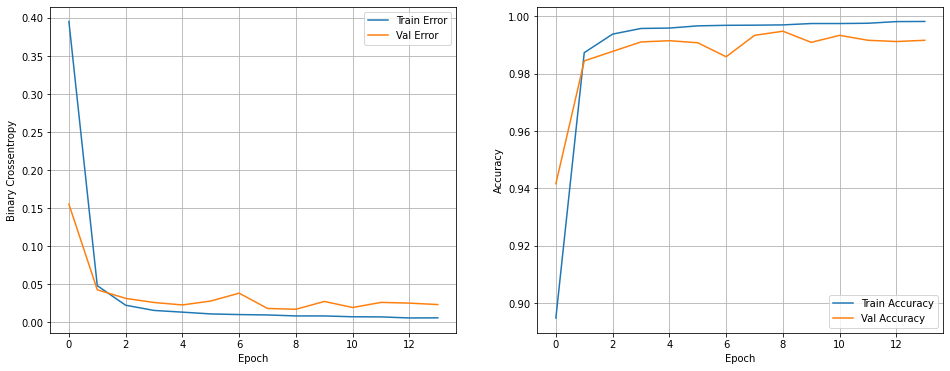

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
show_loss_accuracy_evolution(hist)

<font color='darkblue'> Aplicamos el método *.evaluate* sobre los datos del *test*. Este método predice las clases del array *'X_test_text'* y compara los resultados con el array *'y_test'*, devolviendo las métricas.</n>

In [ ]:
results = Dense_tuned.evaluate(X_test_text, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.08441241085529327
Test Accuracy: 0.973993718624115


<font color='darkblue'> A pesar de que apenas hay *overfitting*, vamos a aplicar regularizadores L2 para estudiar cómo afectan al modelo.</n>

In [ ]:
reg = regularizers.l2(5e-5)


Dense_tuned_2 = Sequential(name='Dense_Tuning_Model')
Dense_tuned_2.add(Dense(64, input_shape=(X_train_text.shape[1], ), kernel_initializer='uniform', activation='relu', name="input_layer", kernel_regularizer=reg))
Dense_tuned_2.add(Dropout(0.2, name="first_dropout"))
Dense_tuned_2.add(Dense(64, kernel_initializer='uniform', activation='relu', name='Dense1', kernel_regularizer=reg))
Dense_tuned_2.add(Dropout(0.2, name="second_dropout"))
Dense_tuned_2.add(Dense(1, kernel_initializer='uniform', activation='sigmoid', name="output_layer"))
Dense_tuned_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

history = Dense_tuned_2.fit(X_train_text,
                    y_train,
                    validation_split=0.25,
                    epochs=20,
                    batch_size=256,
                    callbacks=[es_callback])

Epoch 1/20
82/82 [==============================] - 1s 4ms/step - loss: 0.4004 - accuracy: 0.8636 - val_loss: 0.1815 - val_accuracy: 0.9368
Epoch 2/20
82/82 [==============================] - 0s 2ms/step - loss: 0.0524 - accuracy: 0.9866 - val_loss: 0.0468 - val_accuracy: 0.9855
Epoch 3/20
82/82 [==============================] - 0s 3ms/step - loss: 0.0244 - accuracy: 0.9947 - val_loss: 0.0348 - val_accuracy: 0.9889
Epoch 4/20
82/82 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.9952 - val_loss: 0.0241 - val_accuracy: 0.9934
Epoch 5/20
82/82 [==============================] - 0s 3ms/step - loss: 0.0164 - accuracy: 0.9965 - val_loss: 0.0271 - val_accuracy: 0.9918
Epoch 6/20
82/82 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9965 - val_loss: 0.0269 - val_accuracy: 0.9917
Epoch 7/20
82/82 [==============================] - 0s 3ms/step - loss: 0.0151 - accuracy: 0.9969 - val_loss: 0.0262 - val_accuracy: 0.9922
Epoch 8/20
82/82 [==

In [ ]:
print(Dense_tuned_2.summary())

Model: "Dense_Tuning_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 64)                7424      
                                                                 
 first_dropout (Dropout)     (None, 64)                0         
                                                                 
 Dense1 (Dense)              (None, 64)                4160      
                                                                 
 second_dropout (Dropout)    (None, 64)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 11,649
Trainable params: 11,649
Non-trainable params: 0
_________________________________________________________________
None


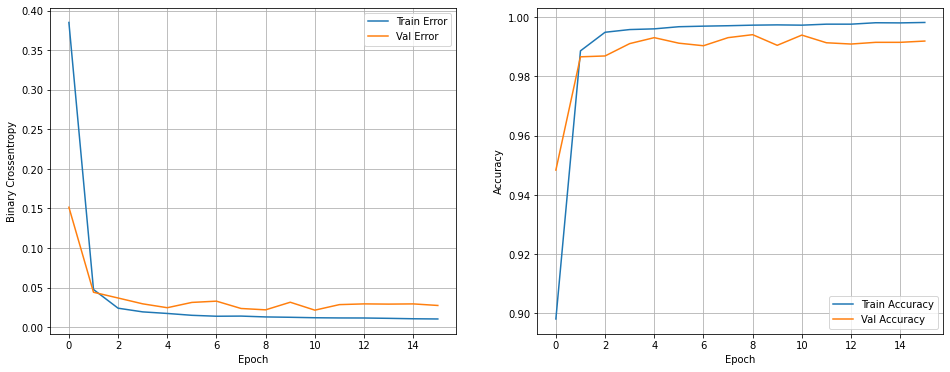

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
show_loss_accuracy_evolution(hist)

In [ ]:
results = Dense_tuned_2.evaluate(X_test_text, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.07248186320066452
Test Accuracy: 0.9797438383102417


<font color='darkblue'> Este modelo ha mejorado algo más los resultados, por lo que nos quedamos con él para hacer predicciones:</n>

In [ ]:
predict_x=Dense_tuned_2.predict(X_test_text) 
y_pred = (predict_x > 0.5).astype('int32')

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      3526
         1.0       0.98      0.98      0.98      4126

    accuracy                           0.98      7652
   macro avg       0.98      0.98      0.98      7652
weighted avg       0.98      0.98      0.98      7652



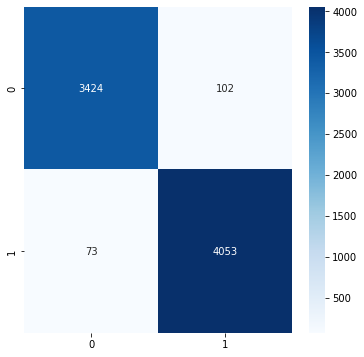

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot = True, cmap="Blues", fmt = "d")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))    


*   <h3>Redes neuronales recurrentes</h3>

<font color='darkblue'> Aplicamos ahora redes LSTM, esta vez ajustando los parámetros de forma manual (los resultados son todos iguales hasta tercer o cuarto orden:</n>

In [ ]:
reg = regularizers.l2(5e-5)

X_train_text3D = X_train_text.reshape(X_train_text.shape[0], 1, X_train_text.shape[-1])

model_LSTM=Sequential(name="Modelo1_LSTM")
model_LSTM.add(LSTM(100, input_shape = (1, X_train_text[0].size), return_sequences=True, kernel_regularizer=reg, dropout=0.2, name="LSTM1"))
model_LSTM.add(LSTM(100, kernel_regularizer=reg, dropout=0.2, name="LSTM2"))
model_LSTM.add(Dense(1,activation='sigmoid', name="Output_Layer"))
model_LSTM.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model_LSTM.summary())

Model: "Modelo1_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 1, 100)            86400     
                                                                 
 LSTM2 (LSTM)                (None, 100)               80400     
                                                                 
 Output_Layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 166,901
Trainable params: 166,901
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=7,
                                            verbose=1)

history = model_LSTM.fit(X_train_text3D,
                    y_train,
                    validation_split=0.25,
                    epochs=20,
                    batch_size=256,
                    callbacks=[es_callback])

Epoch 1/20
82/82 [==============================] - 6s 26ms/step - loss: 0.4155 - accuracy: 0.8673 - val_loss: 0.2827 - val_accuracy: 0.9054
Epoch 2/20
82/82 [==============================] - 7s 80ms/step - loss: 0.1164 - accuracy: 0.9677 - val_loss: 0.0981 - val_accuracy: 0.9707
Epoch 3/20
82/82 [==============================] - 6s 74ms/step - loss: 0.0820 - accuracy: 0.9778 - val_loss: 0.0879 - val_accuracy: 0.9725
Epoch 4/20
82/82 [==============================] - 5s 66ms/step - loss: 0.0719 - accuracy: 0.9799 - val_loss: 0.0865 - val_accuracy: 0.9731
Epoch 5/20
82/82 [==============================] - 4s 45ms/step - loss: 0.0662 - accuracy: 0.9816 - val_loss: 0.0740 - val_accuracy: 0.9764
Epoch 6/20
82/82 [==============================] - 7s 84ms/step - loss: 0.0621 - accuracy: 0.9831 - val_loss: 0.0735 - val_accuracy: 0.9764
Epoch 7/20
82/82 [==============================] - 7s 80ms/step - loss: 0.0601 - accuracy: 0.9839 - val_loss: 0.0734 - val_accuracy: 0.9764
Epoch 8/20
82

In [ ]:
print(model_LSTM.summary())

Model: "Modelo1_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 1, 100)            86400     
                                                                 
 LSTM2 (LSTM)                (None, 100)               80400     
                                                                 
 Output_Layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 166,901
Trainable params: 166,901
Non-trainable params: 0
_________________________________________________________________
None


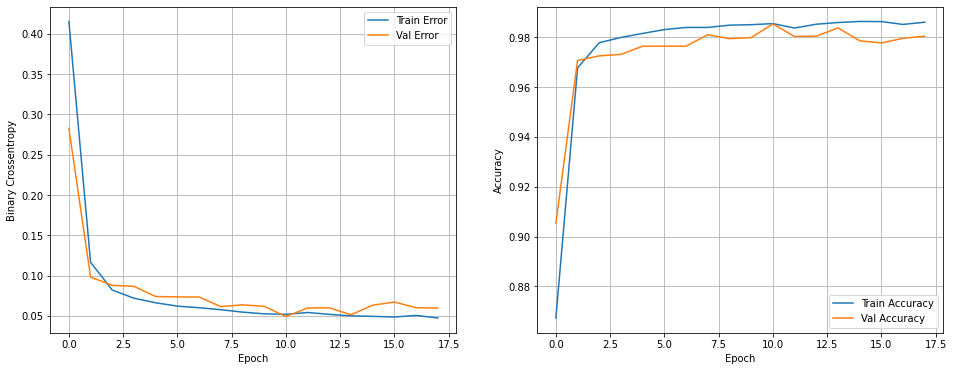

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
show_loss_accuracy_evolution(hist)

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      3526
         1.0       0.98      0.98      0.98      4126

    accuracy                           0.98      7652
   macro avg       0.98      0.98      0.98      7652
weighted avg       0.98      0.98      0.98      7652



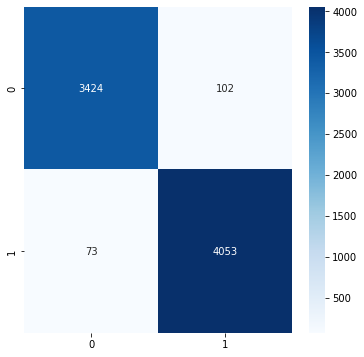

In [ ]:
X_test_words3D = X_test_text.reshape(X_test_text.shape[0], 1, X_test_text.shape[-1])

predict = model_LSTM.predict(X_test_words3D)
y_pred = (predict_x > 0.5).astype('int32')   

m = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot = True, cmap="Blues", fmt = "d")
print(classification_report(y_test, y_pred))    

In [ ]:
X_train_text[0]

array([ 0.10244997,  0.        ,  0.07219727,  0.        ,  0.09792961,
        0.10726456,  0.        ,  0.        ,  0.32414088,  0.09371981,
        0.        ,  0.        ,  0.08254301,  0.25580652,  0.        ,
        0.09213263,  0.        ,  0.07125112,  0.07583806,  0.09476411,
        0.        ,  0.08924734,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.08693944,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.06825389,  0.        ,  0.        ,  0.        ,  0.1096215 ,
        0.        ,  0.09823701,  0.19708076,  0.        ,  0.23697387,
        0.18732522,  0.        ,  0.        ,  0.        ,  0.19191661,
        0.13869121,  0.        ,  0.        ,  0.        ,  0.10531906,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.07306255,  0.        ,  0.        ,  0.53

In [ ]:
print(X_train_text3D.shape)
print(X_train_text.shape[0])

(27826, 1, 115)
27826


*   <h3>Redes neuronales convolucionales y bidireccionales</h3>

In [ ]:
X_train_text3D = X_train_text.reshape(X_train_text.shape[0], X_train_text.shape[-1], 1)

model_CNNB=Sequential(name='Modelo1_CONV')
model_CNNB.add(Conv1D(32, 5, input_shape = (X_train_text[0].size, 1), activation='relu', name='CNN1'))
model_CNNB.add(MaxPool1D())
model_CNNB.add(Conv1D(32, 5, name='CNN2'))
model_CNNB.add(MaxPool1D())
model_CNNB.add(Bidirectional(LSTM(100), name='Bidirectional'))
model_CNNB.add(Dropout(0.3))
model_CNNB.add(Dense(1,activation='sigmoid', name="Output_Layer"))
model_CNNB.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

history =   model_CNNB.fit(X_train_text3D,
                    y_train,
                    validation_split=0.25,
                    epochs=20,
                    batch_size=500,
                    callbacks=[es_callback])

Epoch 1/20
42/42 [==============================] - 42s 750ms/step - loss: 0.6272 - accuracy: 0.6686 - val_loss: 0.9226 - val_accuracy: 0.1358
Epoch 2/20
42/42 [==============================] - 27s 654ms/step - loss: 0.3853 - accuracy: 0.8261 - val_loss: 0.4329 - val_accuracy: 0.7957
Epoch 3/20
42/42 [==============================] - 33s 785ms/step - loss: 0.1925 - accuracy: 0.9301 - val_loss: 0.3692 - val_accuracy: 0.8616
Epoch 4/20
42/42 [==============================] - 33s 794ms/step - loss: 0.1454 - accuracy: 0.9495 - val_loss: 0.3934 - val_accuracy: 0.8469
Epoch 5/20
42/42 [==============================] - 34s 818ms/step - loss: 0.1250 - accuracy: 0.9578 - val_loss: 0.1732 - val_accuracy: 0.9320
Epoch 6/20
42/42 [==============================] - 32s 769ms/step - loss: 0.1015 - accuracy: 0.9644 - val_loss: 0.2478 - val_accuracy: 0.9064
Epoch 7/20
42/42 [==============================] - 23s 557ms/step - loss: 0.0924 - accuracy: 0.9686 - val_loss: 0.1975 - val_accuracy: 0.9280

In [ ]:
print(model_CNNB.summary())

Model: "Modelo1_CONV"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CNN1 (Conv1D)               (None, 111, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 55, 32)           0         
 )                                                               
                                                                 
 CNN2 (Conv1D)               (None, 51, 32)            5152      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 Bidirectional (Bidirectiona  (None, 200)              106400    
 l)                                                              
                                                      

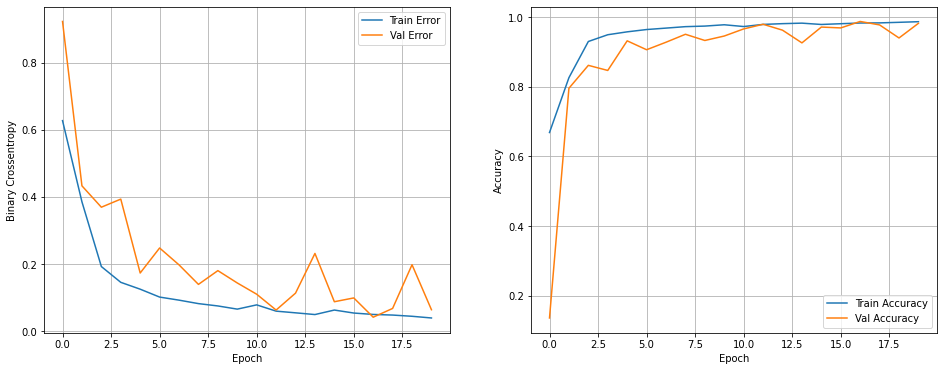

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
show_loss_accuracy_evolution(hist)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      3526
         1.0       0.98      0.98      0.98      4126

    accuracy                           0.98      7652
   macro avg       0.98      0.98      0.98      7652
weighted avg       0.98      0.98      0.98      7652



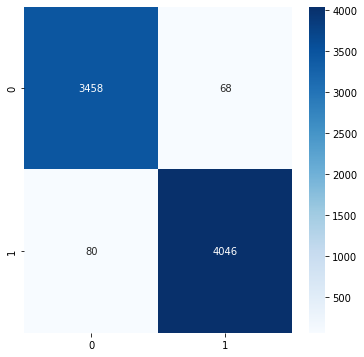

In [ ]:
X_test_words3D = X_test_text.reshape(X_test_text.shape[0], X_test_text.shape[-1], 1)

predict = model_CNNB.predict(X_test_words3D)
y_pred = (predict > 0.5).astype('int32')   

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot = True, cmap="Blues", fmt = "d")
print(classification_report(y_test, y_pred))    

*   <h3>Clasificaciones erróneas</h3>

In [ ]:
pred_label = (y_pred >= 0.5)
print(len(y_pred))

7652


In [ ]:
df = pd.DataFrame(pred_label, columns=['pred_label'])
test_s = test[['text', 'target']]
df_pred = test_s.join(df.set_index(test_s.index)) 
df_pred

,text,target,pred_label
15204,Corruption is nothing new for Hillary and Bill...,0.0,False
2387,DES MOINES (Reuters) - An influential conserva...,1.0,True
311,MADRID (Reuters) - The leader of Spain s Socia...,1.0,True
22106,"Paul Manafort, Donald Trump s new convention m...",0.0,False
24309,TEHRAN (Reuters) - All parties to the Iran nuc...,1.0,True
...,...,...,...
6637,Beware of morning talk show hosts turned news...,0.0,False
23316,WASHINGTON (Reuters) - U.S. Secretary of State...,1.0,True
23861,WASHINGTON (Reuters) - Frustrated U.S. lawmake...,1.0,True
30300,BAGHDAD (Reuters) - Iraq s Supreme Justice Cou...,1.0,True


In [ ]:
Errores_df = df_pred[df_pred.target != df_pred.pred_label]
Errores_df

,text,target,pred_label
23342,WASHINGTON (Reuters) - The chairman of the U.S...,1.0,False
16811,Donald Trump is becoming a liability to the Re...,0.0,True
31007,SAN FRANCISCO (Reuters) - Oracle Corp (ORCL.N)...,1.0,False
34930,"In the coming days, a creationist conspiracy t...",0.0,True
27035,The following statementsÂ were posted to the v...,1.0,False
...,...,...,...
195,WASHINGTON (Reuters) - Milwaukee County Sherif...,1.0,False
19791,"Apparently, the White House is not pleased tha...",0.0,True
14579,21st Century Wire says Ron Paul told RT that t...,0.0,True
7576,GENEVA (Reuters) - Fighting in Yemen s capital...,1.0,False


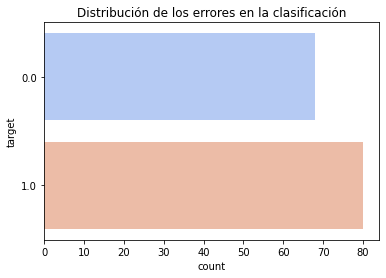

In [ ]:
sns.countplot(y="target", palette="coolwarm", data=Errores_df).set_title('Distribución de los errores en la clasificación')
plt.show()

<font color='darkblue'>Vemos que este último modelo se equivoca más a la hora de clasificar las noticias verdaderas, que las considera falsas, aunque la distribución está bastante balanceada. Este es el único modelo en el que ocurre esto, pues las matrices de confusión de los anteriores nos informaban de que los modelos se equivocaban con más frecuencia  a la hora de identificar las noticias falsas. Veamos algunas de estas noticias:</n>



In [ ]:
mal_clasificadas = df_pred[df_pred.target != df_pred.pred_label].text.values
mal_clasificadas[1]

'Donald Trump is becoming a liability to the Republican Party, so GOP leaders are backing away from their nominee and aligning themselves with President Obama s condemnation of his Muslim ban.Ever since Trump became the nominee, Republicans have been torn between kissing his ass and distancing themselves from his hateful rhetoric. But ever since the Orlando mass shooting, Republicans have been finding themselves stuck between a rock and a hard place.Trump renewed his call to ban Muslims from entering the United States and expanded the idea by calling for banning anybody from a nation that has a history of terrorism against the United States. That could technically mean Japan and Germany as well as many other nations that are now our allies.Trump also claimed that President Obama is weak on terrorism because he hasn t used certain words to somehow make ISIS magically disappear.In response, President Obama took Trump to the woodshed. What exactly would using this language accomplish?  Ob